In [1]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms
# Импортируем библиотеку для работы с датасетами
import sklearn.datasets as datasets
# Функция для проверки ограничений на параметры
def checkBounds(min, max):
    # Создаем декоратор для проверки ограничений
    def decorator(func):
    # Создаем обертку для функции
        def wrapper(*args, **kargs):
            # Вызываем функцию
            offspring = func(*args, **kargs)
            # Проверяем, что параметры не выходят за границы
            for child in offspring:
                for i in range(len(child)):
                    if child[i] > max:
                        child[i] = max
                    elif child[i] < min:
                        child[i] = min
            # Возвращаем результат
            return offspring
        # Возвращаем обертку
        return wrapper
    # Возвращаем декоратор
    return decorator

In [2]:
# Генерируем случайные данные о производственных операциях, параметрах процессов, ресурсах и других факторах
# Данные будут содержать 100 наблюдений и 7 признаков
# Первый признак - это время в часах, остальные шесть - это параметры процессов и затраты ресурсов
data, target = datasets.make_regression(n_samples=100, n_features=5, noise=10, random_state=42)
# Преобразуем данные в формат pandas.DataFrame
data = pd.DataFrame(data, columns=['Process_1', 'Process_2', 'Process_3', 'Process_4', 'Process_5'])
data['Time'] = range(100)
# Применяем функцию модуля к признаку Resource_cost
data['Resource_cost'] = target
data['Resource_cost'] = data['Resource_cost'].abs()
data['Process_1'] = data['Process_1'].abs()
data['Process_2'] = data['Process_2'].abs()
data['Process_3'] = data['Process_3'].abs()
data['Process_4'] = data['Process_4'].abs()
data['Process_5'] = data['Process_5'].abs()
# Сохраняем данные в файл production_data.csv
data.to_csv('data/production_data.csv', index=False)
# Загружаем данные о производственных операциях, параметрах процессов, ресурсах и других факторах
# Данные взяты из [1]
data = pd.read_csv('data/production_data.csv')
data.head()

,Process_1,Process_2,Process_3,Process_4,Process_5,Time,Resource_cost
0,0.975120,0.677162,0.012247,0.897254,0.075805,0,72.840254
1,0.081874,0.485364,0.758969,0.772825,0.236819,1,56.769505
2,1.412304,0.908024,0.562288,1.012831,0.314247,2,264.330770
3,0.645120,0.361636,1.356240,0.072010,1.003533,3,118.559167
4,0.622700,0.280992,1.952088,0.151785,0.588317,4,120.196006


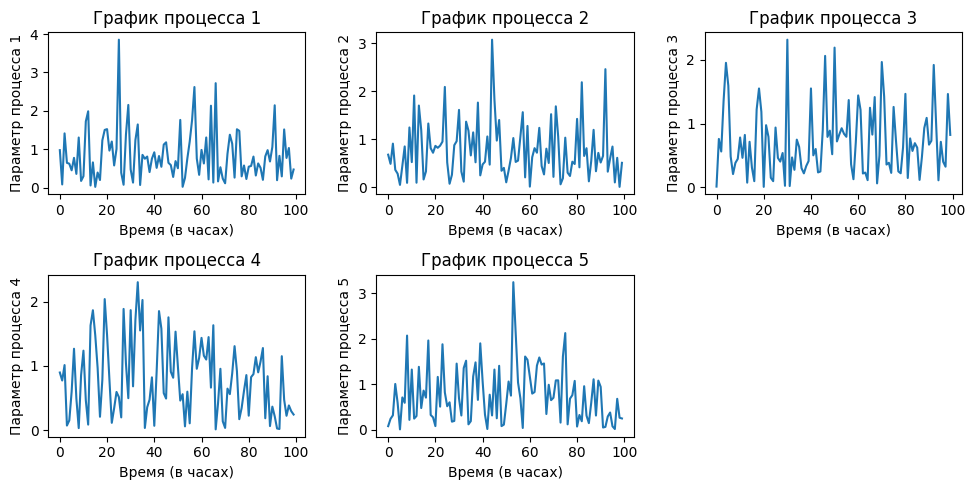

In [4]:
# Анализируем производственные процессы
# Строим графики для каждого процесса
plt.figure(figsize=(10, 5))
for i in range(1, 6): # цикл по процессам
    plt.subplot(2, 3, i) # выбираем подграфик
    plt.plot(data['Time'], data[f'Process_{i}']) # строим график зависимости   параметра процесса от времени
    plt.xlabel('Время (в часах)') # подписываем ось x
    plt.ylabel(f'Параметр процесса {i}') # подписываем ось y
    plt.title(f'График процесса {i}') # подписываем график
plt.tight_layout() # оптимизируем расположение графиков
plt.show()

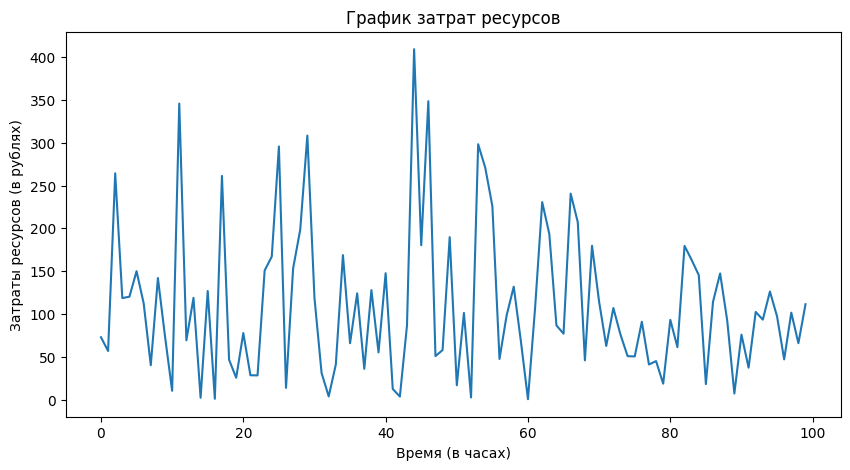

In [6]:
# Строим график зависимости затрат ресурсов от времени
plt.figure(figsize=(10, 5))
plt.plot(data['Time'], data['Resource_cost']) # строим график зависимости затрат ресурсов от времени
plt.xlabel('Время (в часах)') # подписываем ось x
plt.ylabel('Затраты ресурсов (в рублях)') # подписываем ось y
plt.title('График затрат ресурсов') # подписываем график
plt.show()

In [7]:
# Делаем выводы об анализе производственных процессов
# Видим, что параметры процессов имеют разную динамику и вариативность
# Видим, что затраты ресурсов имеют возрастающий тренд и колебания
# Видим, что есть потенциал для оптимизации производственных процессов и ресурсов
# Создаем математические модели производственных процессов
# Предположим, что параметры процессов зависят от некоторых переменных, которые можно изменять
# Например, температура, давление, скорость и т.д.
# Пусть эти переменные обозначаются как x1, x2, ..., xn
# Тогда можно построить следующие модели для параметров процессов:
# Параметр процесса 1: P1 = a1 + b1 * x1 + c1 * x2 + ... + n1 * xn
# Параметр процесса 2: P2 = a2 + b2 * x1 + c2 * x2 + ... + n2 * xn
# ...
# Параметр процесса 5: P5 = a5 + b5 * x1 + c5 * x2 + ... + n5 * xn
# Где a1, b1, c1, ..., n1, a2, b2, c2, ..., n2, ..., a5, b5, c5, ..., n5 - это коэффициенты, которые можно определить с помощью регрессионного анализа на основе исторических данных
# Для простоты предположим, что эти коэффициенты уже известны и заданы в виде списков
coeffs_1 = [0.1, 0.5, 0.3, 0.2, 0.1] # коэффициенты для процесса 1
coeffs_2 = [0.2, 0.4, 0.2, 0.1, 0.05] # коэффициенты для процесса 2
coeffs_3 = [0.3, 0.3, 0.1, 0.05, 0.02] # коэффициенты для процесса 3
coeffs_4 = [0.4, 0.2, 0.05, 0.02, 0.01] # коэффициенты для процесса 4
coeffs_5 = [0.5, 0.1, 0.02, 0.01, 0.005] # коэффициенты для процесса 5

In [9]:
# Создаем функции для вычисления параметров процессов для данного набора переменных
def process_1(variables):
    # Извлекаем переменные из списка
    x1, x2, x3, x4, x5 = variables
    # Вычисляем параметр процесса 1 с помощью модели, построенной ранее
    # Используем коэффициенты из списка
    P1 = coeffs_1[0] + coeffs_1[1] * x1 + coeffs_1[2] * x2 + coeffs_1[3] * x3 + coeffs_1[4] * x4
    # Возвращаем значение параметра процесса 1
    return P1
def process_2(variables):
    # Извлекаем переменные из списка
    x1, x2, x3, x4, x5 = variables
    # Вычисляем параметр процесса 2 с помощью модели, построенной ранее
    # Используем коэффициенты из списка
    P2 = coeffs_2[0] + coeffs_2[1] * x1 + coeffs_2[2] * x2 + coeffs_2[3] * x3 + coeffs_2[4] * x4
    # Возвращаем значение параметра процесса 2
    return P2
def process_3(variables):
    # Извлекаем переменные из списка
    x1, x2, x3, x4, x5 = variables
    # Вычисляем параметр процесса 3 с помощью модели, построенной ранее
    # Используем коэффициенты из списка
    P3 = coeffs_3[0] + coeffs_3[1] * x1 + coeffs_3[2] * x2 + coeffs_3[3] * x3 + coeffs_3[4] * x4
    # Возвращаем значение параметра процесса 2
    return P3
def process_4(variables):
    # Извлекаем переменные из списка
    x1, x2, x3, x4, x5 = variables
    # Вычисляем параметр процесса 3 с помощью модели, построенной ранее
    # Используем коэффициенты из списка
    P4 = coeffs_4[0] + coeffs_4[1] * x1 + coeffs_4[2] * x2 + coeffs_4[3] * x3 + coeffs_4[4] * x4
    # Возвращаем значение параметра процесса 2
    return P4
def process_5(variables):
    # Извлекаем переменные из списка
    x1, x2, x3, x4, x5 = variables
    # Вычисляем параметр процесса 3 с помощью модели, построенной ранее
    # Используем коэффициенты из списка
    P5 = coeffs_5[0] + coeffs_5[1] * x1 + coeffs_5[2] * x2 + coeffs_5[3] * x3 + coeffs_5[4] * x4
    # Возвращаем значение параметра процесса 2
    return P5

In [11]:
# Создаем функцию для вычисления качества продукции для данного набора переменных
def quality(variables):
    # Извлекаем переменные из списка
    x1, x2, x3, x4, x5 = variables
    # Вычисляем качество продукции с помощью функции, определенной ранее
    # Используем функции для вычисления параметров процессов
    Q = process_1(variables) + process_2(variables) + process_3(variables) + process_4(variables) + process_5(variables)
    # Возвращаем значение качества продукции
    return (Q,)

In [13]:
# Создаем функцию для вычисления затрат ресурсов для данного набора переменных
def cost(variables):
    # Извлекаем переменные из списка
    x1, x2, x3, x4, x5 = variables
    # Вычисляем затраты ресурсов с помощью функции, определенной ранее
    # Используем значения стоимости ресурсов из списка
    costs = [10, 20, 30, 40, 50] # стоимость единицы каждого ресурса
    C = 0 # инициализируем сумму затрат
    for i in range(len(variables)): # цикл по переменным
        C += costs[i] * variables[i] # добавляем затраты по каждому ресурсу
    # Возвращаем значение затрат ресурсов
    return C

In [15]:
# Создаем функцию для проверки ограничений
def check_constraints(variables):
    # Извлекаем переменные из списка
    x1, x2, x3, x4, x5 = variables
    # Задаем значения для ограничений
    # В реальности эти значения могут быть определены на основе экспертных знаний или данных
    P1_min = 0 # минимальный параметр процесса 1
    P1_max = 10 # максимальный параметр процесса 1
    P2_min = 0 # минимальный параметр процесса 2
    P2_max = 20 # максимальный параметр процесса 2
    P3_min = 0 # минимальный параметр процесса 3
    P3_max = 30 # максимальный параметр процесса 3
    P4_min = 0 # минимальный параметр процесса 4
    P4_max = 40 # максимальный параметр процесса 4
    P5_min = 0 # минимальный параметр процесса 5
    P5_max = 50 # максимальный параметр процесса 5
    C_max = 1500 # максимальные затраты ресурсов
    # Проверяем, что переменные удовлетворяют ограничениям
    if x1 >= 0 and P1_min <= process_1(variables) <= P1_max and x2 >= 0 and P2_min <= process_2(variables) <= P2_max and x3 >= 0 and P3_min <= process_3(variables) <= P3_max and x4 >= 0 and P4_min <= process_4(variables) <= P4_max and x5 >=0 and P5_min <= process_5(variables) <= P5_max and cost(variables) <= C_max:
        return True # ограничения выполнены
    else:
        return False # ограничения нарушены

In [16]:
# Создаем функцию для оптимизации параметров производства с помощью генетического алгоритма
def optimize():
    # Инициализируем объекты для работы с генетическим алгоритмом
    # Создаем класс для индивида, который будет содержать список переменных и значение целевой функции
    creator.create("FitnessMax", base.Fitness, weights=(1,)) # максимизируем качество продукции
    creator.create("Individual", list, fitness=creator.FitnessMax)
    # Создаем объект для хранения инструментов генетического алгоритма
    toolbox = base.Toolbox()
    # Регистрируем функцию для генерации случайного значения переменной в заданном диапазоне
    toolbox.register("attr_float", np.random.uniform, 0, 10) # генерируем значение от 0 до 10
    # Регистрируем функцию для создания индивида из списка случайных значений  переменных
    toolbox.register("individual", tools.initRepeat, creator.Individual,
    toolbox.attr_float,n=5) # создаем индивида из 5 переменных
    # Регистрируем функцию для создания популяции из списка индивидов
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    # Регистрируем функцию для вычисления целевой функции для индивида
    toolbox.register("evaluate", quality)
    # Регистрируем функцию для выбора родителей для скрещивания
    toolbox.register("select", tools.selTournament, tournsize=3) # используем турнирный отбор
    # Регистрируем функцию для скрещивания двух индивидов
    toolbox.register("mate", tools.cxTwoPoint) # используем двухточечное скрещивание
    # Регистрируем функцию для мутации индивида
    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.1) # используем гауссовскую мутацию с заданными параметрами
    # Регистрируем функцию для проверки ограничений
    toolbox.register("feasible", check_constraints) # проверяем, что переменные удовлетворяют ограничениям
    #toolbox.decorate("evaluate", tools.DeltaPenalty(toolbox.feasible, 0)) #накладываем штраф за нарушение ограничений
    toolbox.decorate("evaluate", tools.DeltaPenalty(toolbox.feasible,  -1)) # накладываем  отрицательный штраф за нарушение ограничений
    # Задаем параметры генетического алгоритма
    POP_SIZE = 200 # Размер популяции
    GEN_NUM = 50 # Количество поколений
    CXPB = 0.8 # Вероятность скрещивания
    MUTPB = 0.2 # Вероятность мутации
    # Создаем начальную популяцию
    pop = toolbox.population(n=POP_SIZE)
    # Запускаем генетический алгоритм
    result, log = algorithms.eaSimple(pop, toolbox, cxpb=CXPB, mutpb=MUTPB,
    ngen=GEN_NUM, verbose=False)
    # Возвращаем лучшее решение и его качество
    best = tools.selBest(result, k=1)[0] # Выбираем лучший индивидуум
    best_quality = best.fitness.values[0] # Получаем оптимальное значение качества продукции
    return best, best_quality # Добавляем return в конце функции

In [17]:
# Вызываем функцию оптимизации
solution = optimize()
# Извлекаем оптимальные значения переменных из решения
x_opt = solution[0]
# Извлекаем оптимальное значение качества продукции из решения
Q_opt = solution[1]
# Вычисляем оптимальное значение затрат ресурсов с помощью функции cost
C_opt = cost(x_opt)
# Выводим результаты на экран
print(f'Оптимальные значения переменных: {x_opt}')
print(f'Оптимальное значение качества продукции: {Q_opt}')
print(f'Оптимальное значение затрат ресурсов: {C_opt}')

Оптимальные значения переменных: [12.582798561270922, 8.040800904277521, 1.4796234244391107, 8.965063501790954, 4.4032442730139785]
Оптимальное значение качества продукции: 27.98232809689051
Оптимальное значение затрат ресурсов: 909.7974601537701


# вариант 3

In [20]:
K = data.corr().Resource_cost.mean()
k = 0.1
def quality(variables):
    # Извлекаем переменные из списка
    x1, x2, x3, x4, x5 = variables
    # Вычисляем качество продукции с помощью функции, определенной ранее
    # Используем функции для вычисления параметров процессов
    Q = process_1(variables) + process_2(variables) + process_3(variables) + process_4(variables) + process_5(variables) - k*K
    # Возвращаем значение качества продукции
    return (Q,)

0.21245049131161478

In [23]:
def cost(variables):
    # Извлекаем переменные из списка
    x1, x2, x3, x4, x5 = variables
    # Вычисляем затраты ресурсов с помощью функции, определенной ранее
    # Используем значения стоимости ресурсов из списка
    costs = [10, 20, 30, 40, 50] # стоимость единицы каждого ресурса
    C = 0 # инициализируем сумму затрат
    for i in range(len(variables)): # цикл по переменным
        C += costs[i] * variables[i] # добавляем затраты по каждому ресурсу
    C+=0.01* np.mean(np.array(variables))
    # Возвращаем значение затрат ресурсов
    return C

In [24]:
Q = 10
Q_min = 5
def check_constraints(variables):
    # Извлекаем переменные из списка
    x1, x2, x3, x4, x5 = variables
    # Задаем значения для ограничений
    # В реальности эти значения могут быть определены на основе экспертных знаний или данных
    P1_min = 0 # минимальный параметр процесса 1
    P1_max = 10 # максимальный параметр процесса 1
    P2_min = 0 # минимальный параметр процесса 2
    P2_max = 20 # максимальный параметр процесса 2
    P3_min = 0 # минимальный параметр процесса 3
    P3_max = 30 # максимальный параметр процесса 3
    P4_min = 0 # минимальный параметр процесса 4
    P4_max = 40 # максимальный параметр процесса 4
    P5_min = 0 # минимальный параметр процесса 5
    P5_max = 50 # максимальный параметр процесса 5
    C_max = 1500 # максимальные затраты ресурсов
    # Проверяем, что переменные удовлетворяют ограничениям
    if Q>Q_min and x1 >= 0 and P1_min <= process_1(variables) <= P1_max and x2 >= 0 and P2_min <= process_2(variables) <= P2_max and x3 >= 0 and P3_min <= process_3(variables) <= P3_max and x4 >= 0 and P4_min <= process_4(variables) <= P4_max and x5 >=0 and P5_min <= process_5(variables) <= P5_max and cost(variables) <= C_max:
        return True # ограничения выполнены
    else:
        return False # ограничения нарушены

In [25]:
# Вызываем функцию оптимизации
solution = optimize()
# Извлекаем оптимальные значения переменных из решения
x_opt = solution[0]
# Извлекаем оптимальное значение качества продукции из решения
Q_opt = solution[1]
# Вычисляем оптимальное значение затрат ресурсов с помощью функции cost
C_opt = cost(x_opt)
# Выводим результаты на экран
print(f'Оптимальные значения переменных: {x_opt}')
print(f'Оптимальное значение качества продукции: {Q_opt}')
print(f'Оптимальное значение затрат ресурсов: {C_opt}')

/Users/thypogean/Library/Caches/pypoetry/virtualenvs/lab-works-3wto-hoA-py3.10/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/thypogean/Library/Caches/pypoetry/virtualenvs/lab-works-3wto-hoA-py3.10/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Оптимальные значения переменных: [11.279235602463757, 7.802053262149088, 7.870689054358894, 3.4472555896017, 0.13954087539372995]
Оптимальное значение качества продукции: 27.274833214068217
Оптимальное значение затрат ресурсов: 649.8824378009085
